# Diffusion on a 2D Exponentially Tilted Uniform Measure on a Circle

In this notebook we:

1. Create a uniform variable \(t\) on \([0,1]\) and map it to a circle via
   \[
     f(t) = \Big(R\cos(2\pi t),\, R\sin(2\pi t)\Big)
   \]
   so that the data lie on a circle.

2. Define an exponential tilt in 2D with
   \[
     w(x,y) = \exp(\theta_1\,x + \theta_2\,y)
   \]
   so that the twisted density is \(Q(x,y)\propto P(x,y)\,w(x,y)\).

3. Use two techniques:
   - **Rejection Sampling:** Generate samples from \(Q\) using rejection sampling.
   - **Weighted Loss:** Train a diffusion model on \(P\) while weighting the loss by \(w(x,y)\).

4. Train a diffusion model (with a simple neural network) on the tilted data and generate samples using DDPM.


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Define the Circle Mapping and Create the Base Dataset

We define a mapping from \(t\in[0,1]\) to the circle of radius \(R\):

\[
  f(t) = \big(R\cos(2\pi t),\, R\sin(2\pi t)\big).
\]

Then we generate a set of \(P\) samples.

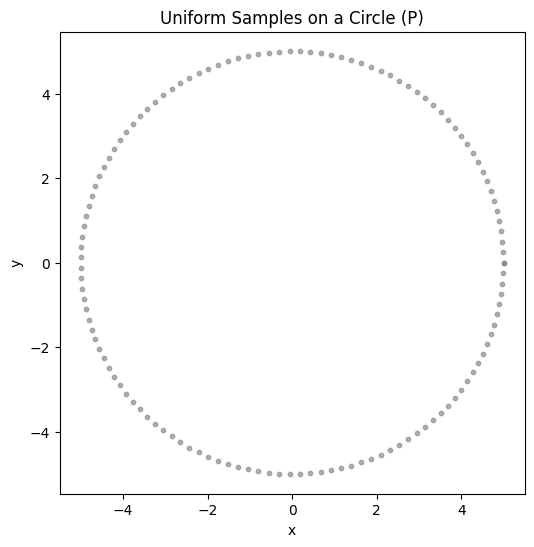

In [37]:
R = 5.0  # radius of the circle

def f(t):
    """Map t in [0,1] to a point on a circle of radius R."""
    theta = 2 * np.pi * t
    x = R * np.cos(theta)
    y = R * np.sin(theta)
    return np.stack([x, y], axis=1)

# Generate uniform samples in t and map to the circle.
n_samples = 128
t_uniform = np.linspace(0, 1, n_samples)
data_uniform = f(t_uniform)

# Plot the uniform (base) data on the circle.
plt.figure(figsize=(6,6))
plt.scatter(data_uniform[:,0], data_uniform[:,1], s=10, color='gray', alpha=0.6)
plt.title("Uniform Samples on a Circle (P)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()

## 2. Define the 2D Exponential Tilt

We now define a two-dimensional tilt parameter 
\[
\theta=(\theta_1,\theta_2).
\]
The tilt weight for a point \((x,y)\) is 
\[
w(x,y)=\exp(\theta_1 x + \theta_2 y).
\]
For rejection sampling, note that on the circle the maximum value of \(\theta_1 x+\theta_2 y\)
is \(R\|\theta\|\). Therefore, we set
\[
M = \exp(R\|\theta\|).
\]

In [38]:
# Choose a 2D tilt
theta2d = np.array([0.0, 0.0])
norm_theta = np.linalg.norm(theta2d)
M = np.exp(R * norm_theta)
print("Theta:", theta2d, "  ||theta|| =", norm_theta, "  M =", M)

Theta: [0. 0.]   ||theta|| = 0.0   M = 1.0


## 3. Rejection Sampling to Generate Tilted Samples

Given the base dataset \(P\) (samples on the circle), we generate samples from
the tilted density
\[
Q(x,y) \propto P(x,y)\,\exp(\theta_1 x + \theta_2 y)
\]
by accepting a candidate \((x,y)\) with probability
\[
A(x,y) = \frac{\exp(\theta_1 x + \theta_2 y)}{M}.
\]

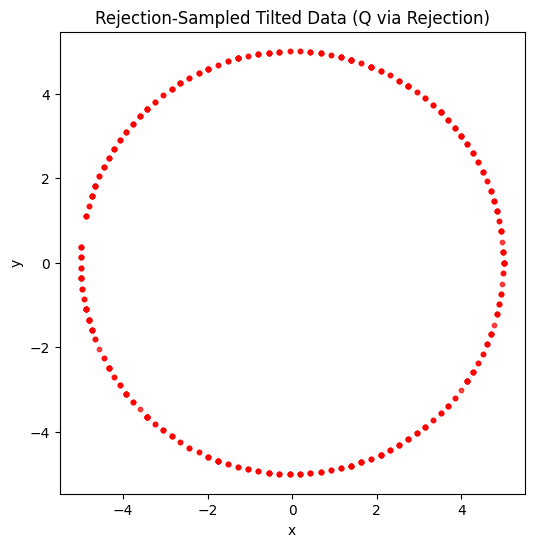

In [39]:
def rejection_sample_2d(data, theta2d, n_samples_desired):
    weights = np.exp(np.dot(data, theta2d))
    M = np.max(weights)

    samples = []
    while len(samples) < n_samples_desired:
        # Randomly pick an index from the base data
        idx = np.random.randint(0, data.shape[0])
        x = data[idx]
        weight = weights[idx]
        
        if M * np.random.rand() < weight:
            samples.append(x)
    return np.array(samples)

n_tilted = 512
data_tilted_rej = rejection_sample_2d(data_uniform, theta2d, n_tilted)

# Plot the rejection-sampled tilted data.
plt.figure(figsize=(6,6))
plt.scatter(data_tilted_rej[:,0], data_tilted_rej[:,1], s=10, color='red', alpha=0.7)
plt.title("Rejection-Sampled Tilted Data (Q via Rejection)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()

## 4. Diffusion Model Setup

We now define the diffusion parameters, a simple diffusion model, and the DDPM sampling procedure.

### 4.1 Diffusion Utilities

In [40]:
def get_diffusion_params(T, device):
    # Linear schedule for betas
    betas = np.linspace(1e-4, 0.02, T)
    alphas = 1 - betas
    alpha_bars = np.cumprod(alphas)
    betas = torch.tensor(betas, dtype=torch.float32, device=device)
    alphas = torch.tensor(alphas, dtype=torch.float32, device=device)
    alpha_bars = torch.tensor(alpha_bars, dtype=torch.float32, device=device)
    return betas, alphas, alpha_bars

class DiffusionModel(nn.Module):
    def __init__(self, time_embedding_dim=32, hidden_dim=256, num_layers=4):
        super().__init__()
        self.time_embedding = nn.Sequential(
            nn.Linear(1, time_embedding_dim),
            nn.ReLU(),
            nn.Linear(time_embedding_dim, time_embedding_dim),
        )
        layers = [nn.Linear(2 + time_embedding_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, 2))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x, t):
        t_emb = self.time_embedding(t)
        x_input = torch.cat([x, t_emb], dim=1)
        return self.net(x_input)

@torch.no_grad()
def sample_diffusion_ddpm(model, num_samples, T, betas, alphas, alpha_bars, device):
    model.eval()
    x = torch.randn(num_samples, 2, device=device)
    samples = [x.cpu().numpy()]
    for t in reversed(range(1, T)):
        t_tensor = torch.full((num_samples, 1), t / T, device=device)
        eps = model(x, t_tensor)
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        alpha_bar_prev = alpha_bars[t-1]
        z = torch.randn_like(x)
        x0 = (1/torch.sqrt(alpha_bar_t))*(x - torch.sqrt(1-alpha_bar_t)*eps)
        mu = (torch.sqrt(alpha_t) * (1 - alpha_bar_prev) / (1 - alpha_bar_t)) * x \
             + (torch.sqrt(alpha_bar_prev) * beta_t / (1 - alpha_bar_t)) * x0
        noise = torch.sqrt(beta_t*(1 - alpha_bar_prev)/(1 - alpha_bar_t)) * z
        x = mu + noise
        samples.append(x.cpu().numpy())
    return np.array(samples)

## 5. Training the Diffusion Model: Two Approaches

We now implement two training routines:

1. **Rejection Sampling Approach:** We use the rejection‐sampled tilted dataset \(Q\) (from section 3) and train the model with a standard MSE loss.

2. **Weighted Loss Approach:** We train on the original dataset \(P\) (the full circle) but weight each sample’s loss by 
   \(\exp(\theta_1 x + \theta_2 y)\).

In [41]:
def train_diffusion_rejection(data, num_epochs=300, T=100, batch_size=128, device=device, print_every=5):
    # data is already from Q (tilted via rejection sampling)
    data_tensor = torch.tensor(data, dtype=torch.float32, device=device)
    dataset = TensorDataset(data_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    betas, alphas, alpha_bars = get_diffusion_params(T, device)
    model = DiffusionModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in range(1, num_epochs + 1):
        epoch_loss = 0
        for _ in range(T):
            for (x0,) in dataloader:
                B = x0.size(0)
                t_idx = torch.randint(0, T, (B,), device=device)
                noise = torch.randn_like(x0)
                sqrt_alpha_bar = torch.sqrt(alpha_bars[t_idx]).unsqueeze(1)
                sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bars[t_idx]).unsqueeze(1)
                x_t = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise
                t_norm = (t_idx.float()/T).unsqueeze(1)
                noise_pred = model(x_t, t_norm)
                loss = ((noise_pred - noise)**2).mean()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
        
        if epoch % print_every == 0 or epoch == 1:
            epoch_loss /= (T * len(dataloader))
            print(f"Epoch {epoch}/{num_epochs} Loss: {epoch_loss}")
    return model, betas, alphas, alpha_bars

def train_diffusion_weighted(data, theta2d, num_epochs=300, T=100, batch_size=128, device=device, print_every=5):
    # data is the original (uniform) dataset on the circle
    data_tensor = torch.tensor(data, dtype=torch.float32, device=device)
    # Compute weight for each sample: exp(theta1*x + theta2*y)
    weights_np = np.exp(np.dot(data, theta2d))
    weights_tensor = torch.tensor(weights_np, dtype=torch.float32, device=device)
    dataset = TensorDataset(data_tensor, weights_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    max_weight = weights_np.max()
    
    betas, alphas, alpha_bars = get_diffusion_params(T, device)
    model = DiffusionModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in range(1, num_epochs + 1):
        epoch_loss = 0
        for _ in range(T):
            for (x0, w) in dataloader:
                B = x0.size(0)
                t_idx = torch.randint(0, T, (B,), device=device)
                noise = torch.randn_like(x0)
                sqrt_alpha_bar = torch.sqrt(alpha_bars[t_idx]).unsqueeze(1)
                sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bars[t_idx]).unsqueeze(1)
                x_t = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise
                t_norm = (t_idx.float()/T).unsqueeze(1)
                noise_pred = model(x_t, t_norm)
                # Multiply the squared error by the per-sample weight.
                loss = (w.unsqueeze(1) * ((noise_pred - noise)**2)).mean() / max_weight
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
        
        if epoch % print_every == 0 or epoch == 1:
            epoch_loss /= (T * len(dataloader))
            print(f"Epoch {epoch}/{num_epochs} Loss: {epoch_loss}")
    return model, betas, alphas, alpha_bars

## 6. Training and Sampling

We train two diffusion models—one using the rejection-sampled dataset and one using weighted loss—and then generate samples via DDPM.

In [42]:
# Set diffusion parameters
T_steps = 1000
epochs = 5
print_every = 1
batch_size = 512
n_samples = 1024
theta2d = np.array([1.0, 1.0]) * 1

t_uniform = np.linspace(0, 1, n_samples)
data_uniform = f(t_uniform)
data_tilted_rej = rejection_sample_2d(data_uniform, theta2d, n_samples)

# (a) Train on tilted data generated by rejection sampling
print("Training diffusion model on rejection-sampled tilted data ...")
model_rej, betas_rej, alphas_rej, alpha_bars_rej = train_diffusion_rejection(data_tilted_rej, num_epochs=epochs, batch_size=batch_size, T=T_steps, device=device, print_every=print_every)

# (b) Train on the original data with weighted loss
print("\nTraining diffusion model with weighted loss ...")
model_weighted, betas_w, alphas_w, alpha_bars_w = train_diffusion_weighted(data_uniform, theta2d, num_epochs=epochs, batch_size=batch_size, T=T_steps, device=device, print_every=print_every)

Training diffusion model on rejection-sampled tilted data ...
Epoch 1/5 Loss: 0.22091690932959318
Epoch 2/5 Loss: 0.20151923459768295
Epoch 3/5 Loss: 0.2008048257827759
Epoch 4/5 Loss: 0.20001019106805323
Epoch 5/5 Loss: 0.19947146962583065

Training diffusion model with weighted loss ...
Epoch 1/5 Loss: 0.03623889392055571
Epoch 2/5 Loss: 0.032126295391470196
Epoch 3/5 Loss: 0.032166081172879786
Epoch 4/5 Loss: 0.0319896361194551
Epoch 5/5 Loss: 0.031844445317983625


In [43]:
# Generate samples from each trained model using DDPM sampling.
num_gen = 500

samples_rej = sample_diffusion_ddpm(model_rej, num_gen, T_steps, betas_rej, alphas_rej, alpha_bars_rej, device)
samples_weighted = sample_diffusion_ddpm(model_weighted, num_gen, T_steps, betas_w, alphas_w, alpha_bars_w, device)

# Use the final step (last frame) as the generated sample.
final_rej = samples_rej[-1]
final_weighted = samples_weighted[-1]

# Print mean (x, y) of actual data using e^theta.x as weights, mean (x, y) of each generated sample.
weights = np.exp(np.dot(data_uniform, theta2d))
weighted_avg = np.sum(data_uniform * weights[:, None], axis=0) / np.sum(weights)
rejection_data_mean = np.mean(data_tilted_rej, axis=0)
print(f"[DATA] Weighted Average            : ({weighted_avg[0]:.4f}, {weighted_avg[1]:.4f})")
print(f"[DATA] Rejection Sample            : ({rejection_data_mean[0]:.4f}, {rejection_data_mean[1]:.4f})")

rej_avg = np.mean(final_rej, axis=0)
weighted_avg = np.mean(final_weighted, axis=0)
# print(f"Rejection-Sampled Average x: {rej_avg[0]:.4f}, Average y: {rej_avg[1]:.4f}")

print(f"[SAMPLED] Rejection-Sampled Average: ({rej_avg[0]:.4f}, {rej_avg[1]:.4f})")
print(f"[SAMPLED] Weighted Loss Average    : ({weighted_avg[0]:.4f}, {weighted_avg[1]:.4f})")

[DATA] Weighted Average            : (3.2764, 3.2724)
[DATA] Rejection Sample            : (3.3088, 3.2640)
[SAMPLED] Rejection-Sampled Average: (3.3766, 3.1987)
[SAMPLED] Weighted Loss Average    : (3.1729, 3.3476)


## 7. Results Comparison

We now plot the generated samples from each model alongside the original (base) data.


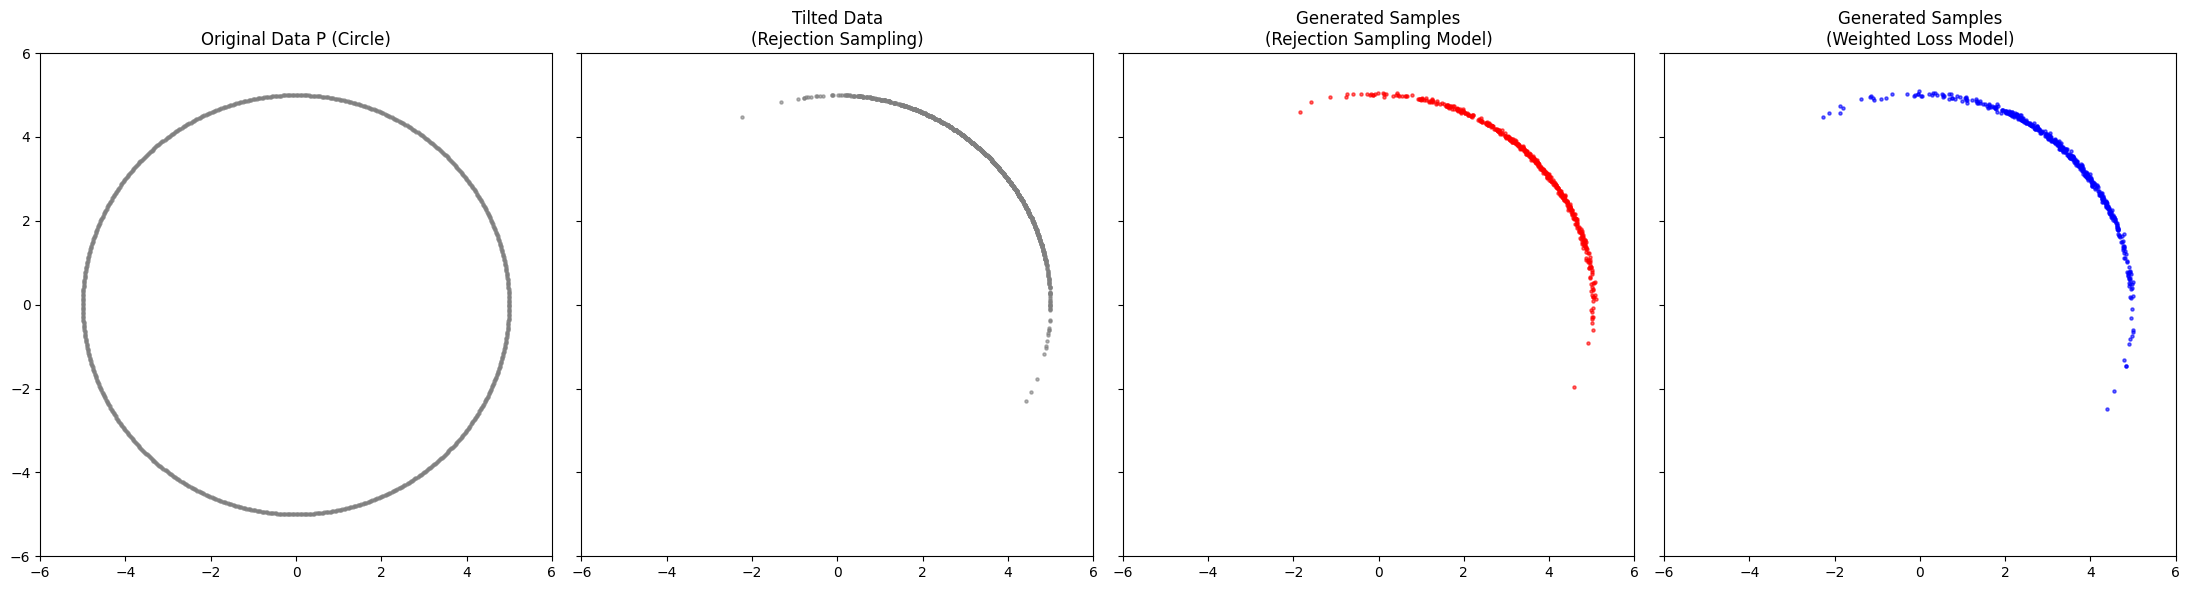

In [44]:
fig, axes = plt.subplots(1, 4, figsize=(22, 6), sharey=True)

axes[0].scatter(data_uniform[:, 0], data_uniform[:, 1], s=5, color='gray', alpha=0.6)
axes[0].set_title("Original Data P (Circle)")
axes[0].set_xlim(-6, 6)
axes[0].set_ylim(-6, 6)

axes[1].scatter(data_tilted_rej[:, 0], data_tilted_rej[:, 1], s=5, color='gray', alpha=0.6)
axes[1].set_title("Tilted Data\n(Rejection Sampling)")
axes[1].set_xlim(-6, 6)
axes[1].set_ylim(-6, 6)

axes[2].scatter(final_rej[:, 0], final_rej[:, 1], s=5, color='red', alpha=0.6)
axes[2].set_title("Generated Samples\n(Rejection Sampling Model)")
axes[2].set_xlim(-6, 6)
axes[2].set_ylim(-6, 6)

axes[3].scatter(final_weighted[:, 0], final_weighted[:, 1], s=5, color='blue', alpha=0.6)
axes[3].set_title("Generated Samples\n(Weighted Loss Model)")
axes[3].set_xlim(-6, 6)
axes[3].set_ylim(-6, 6)

plt.tight_layout()
plt.show()

## 8. Conclusion

In this notebook we demonstrated two approaches to twist a 2D dataset on a circle:

- By using rejection sampling to directly generate samples from the tilted distribution \(Q\).
- By incorporating the exponential weight into the diffusion loss when training a model on the original data \(P\).

The diffusion models trained with these two strategies can then be used to generate samples that reflect the exponential tilt defined by \(\theta=(\theta_1,\theta_2)\).